# Filtering in the time domain vs frequency domain

In signal processing, filters attenuate unwanted frequencies in the stopband, leaving behind the signal of interest in the passband. An ideal filter removes all signal in the stop band and leaves the signal in the passband unchanged. Such a filter can be realized in the frequency domain. After taking the Fourier transform of the signal, set the amplitude of the stopband to zero and then take the inverse transform.

Nevertheless, filtering is often performed in the time domain, for example with a Butterworth Filter. A Butterworth Filter is not ideal because it has a slow rolloff, while a filter in the frequency domain can have a perfect cutoff. Why is a Butterworth Filter used? What are the advantages of filtering in the time domain vs. the frequency domain?

To answer these questions, we will use some data from the LIGO Open Science Center. This is the data from the first observation of a gravitational wave. I chose this data because there is a very good theoretical prediction for what the data should look like, and the data is a good match when using a Butterworth Filter.

http://stackoverflow.com/questions/2929401/dsp-filtering-in-the-frequency-domain-via-fft

http://dsp.stackexchange.com/questions/6220/why-is-it-a-bad-idea-to-filter-by-zeroing-out-fft-bins

http://www.dspguide.com/ch21/2.htm


In [1]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl

In [2]:

# Cutoff frequencies for bandpass filter
fc_low  = 20.
fc_high = 300.
fs = 4096 #Hz, sampling rate

tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 


nfft = 1 * fs

# Load and prepare data (following LIGO tutorial)

In [3]:
# Load data

# Real data recorded by LIGO H1 detector
strain, time, chan_dict = rl.loaddata('H-H1_LOSC_4_V1-1126259446-32.hdf5', 'H1')

# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# This is the theoretical value that should match the filtered data.
NRtime, NR_H1 = np.genfromtxt('GW150914_4_NR_waveform.txt').transpose()

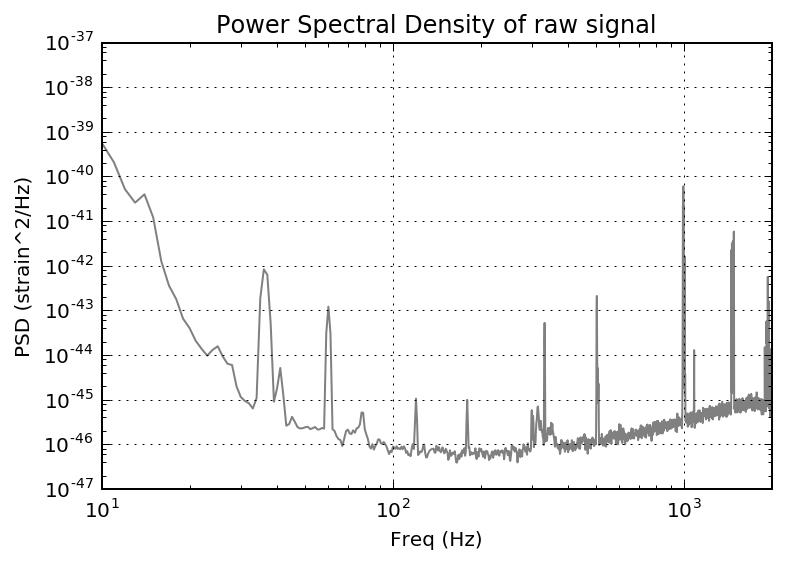

In [4]:
# Plot the power spectral density of the recorded strain
def plot_psd(x, fs, nfft=fs, fmin=10, fmax=2000):
    Pxx, freqs = mlab.psd(x, Fs = fs, NFFT = nfft)
    lines = plt.loglog(freqs, Pxx)
    plt.grid('on')
    plt.ylabel('PSD (strain^2/Hz)')
    plt.xlabel('Freq (Hz)')    
    plt.xlim([fmin, fmax])
    return lines[0]

line = plot_psd(strain, fs)
line.set_color('gray')
plt.title('Power Spectral Density of raw signal')

In [5]:
# Whiten
# copied from LIGO tutorial

# function to writen data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data from H1 and also the NR template:
Pxx_H1, freqs = mlab.psd(strain, Fs = fs, NFFT = nfft)
psd_H1 = interp1d(freqs, Pxx_H1)
strain_whiten = whiten(strain,psd_H1,dt)
NR_whiten = whiten(NR_H1,psd_H1,dt)

## Filter in the time domain (butterworth)

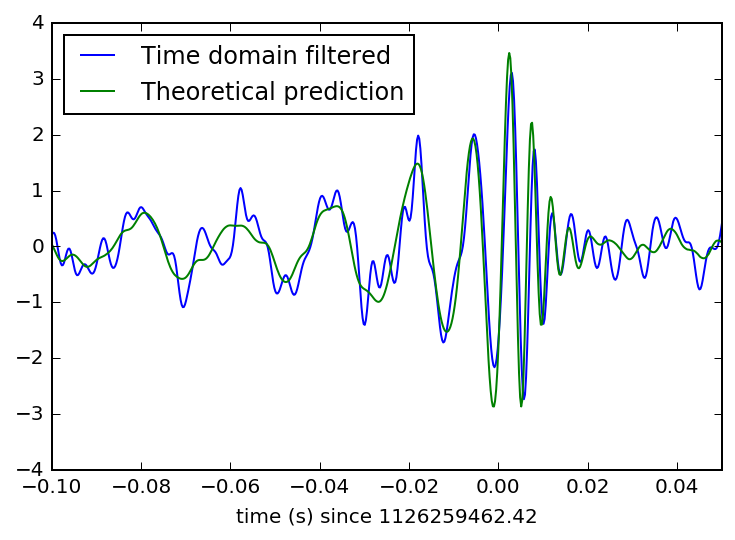

In [6]:
# Bandpass filter in the time domain (as in the tutorial)
def bandpass_time_domain(x, fs, f1, f2):
    bb, ab = butter(4, [f1 * 2. / fs, f2 * 2. / fs], btype='band')
    y = filtfilt(bb, ab, x)
    return y

def plot_data(t, y, **kwargs):
    lines = plt.plot(t, y, **kwargs)
    plt.xlim([-0.1, 0.05])
    plt.ylim([-4, 4])
    plt.xlabel('time (s) since '+str(tevent))
    return lines[0]

strain_filtered_t = bandpass_time_domain(strain_whiten, fs, fc_low, fc_high)
plot_data(time - tevent, strain_filtered_t, label='Time domain filtered')
plot_data(NRtime + 0.002, NR_whiten, label='Theoretical prediction')
plt.legend(loc='upper left')

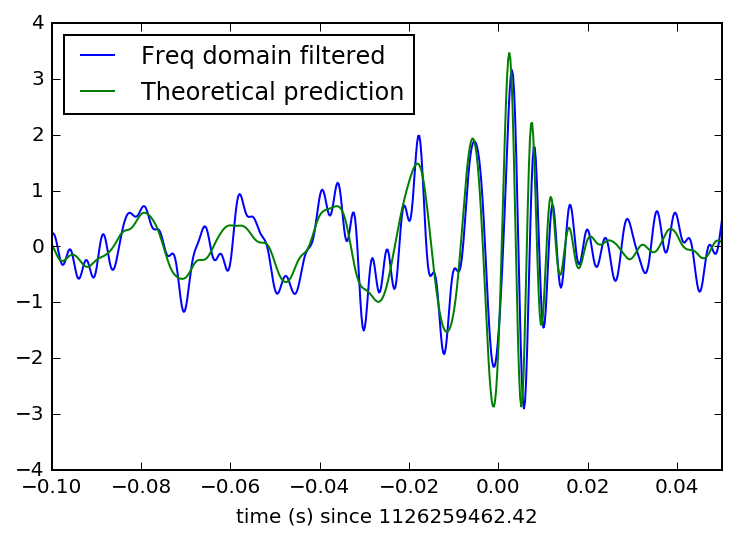

In [7]:
# Bandpass filter in the time domain (as in the tutorial)
def bandpass_freq_domain(x, fs, f1, f2):
    # transform to frequency domain
    Nt = len(x)
    freqs = np.fft.rfftfreq(Nt, dt)
    X = np.fft.rfft(x)
    
    # Set amplitude to zero for freqs outside passband
    X_BP = [0 if f < f1 or f > f2 else amp for f,amp in zip(freqs, X)]
    
    # Inverse transform back to time domain
    x_bp = np.fft.irfft(X_BP, n=Nt)
    return x_bp

strain_filtered_f = bandpass_freq_domain(strain_whiten, fs, fc_low, fc_high)
plot_data(time - tevent, strain_filtered_f, label='Freq domain filtered')
plot_data(NRtime + 0.002, NR_whiten, label='Theoretical prediction')
plt.legend(loc='upper left')

## A more detailed comparison

Regardless of filtering method, the results seem to match the theoretical prediction. Let's compare the two filtering methods to each other.

In [9]:
# Residuals of filtered data to theoretical
residual_f = np.interp(NRtime + 0.002, time - tevent, strain_filtered_f) - NR_whiten
residual_t = np.interp(NRtime + 0.002, time - tevent, strain_filtered_t) - NR_whiten

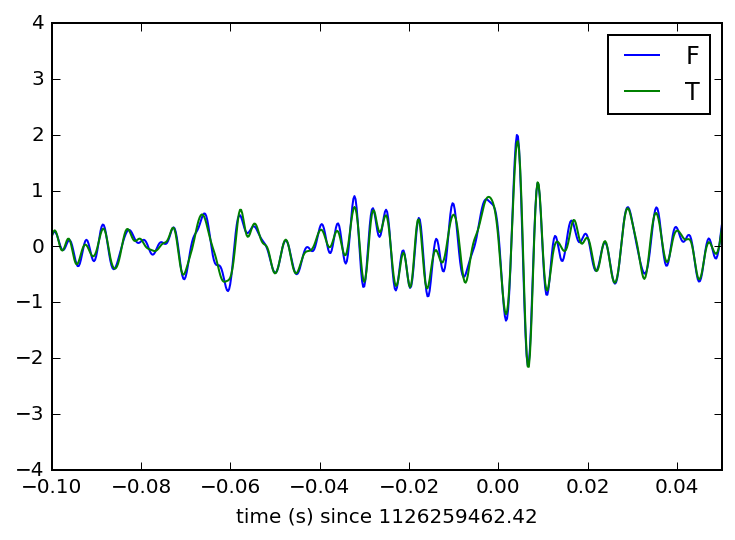

In [11]:
plot_data(NRtime + 0.002, residual_f, label='F')
plot_data(NRtime + 0.002, residual_t, label='T')
plt.legend()

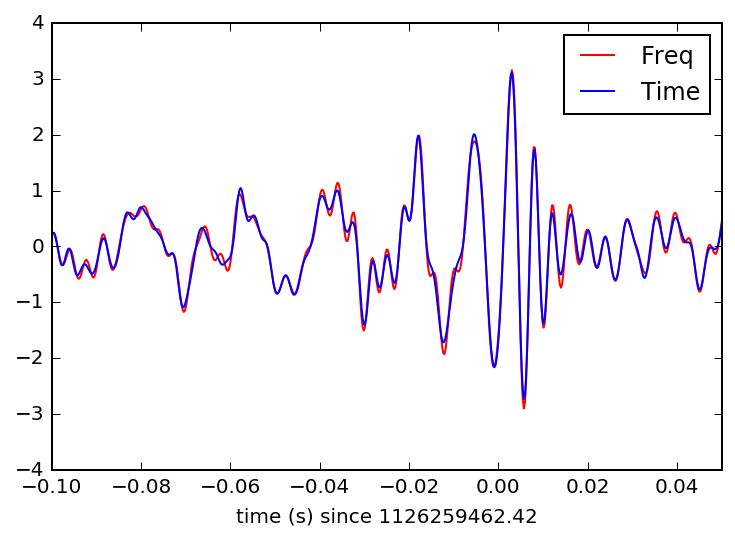

In [39]:
# Plot filtered results on top of each other (H1 only for simplicity)
line_f = plot_data(time - tevent, strain_filtered_f)
line_t = plot_data(time - tevent, strain_filtered_t)
line_f.set_color('red')
line_t.set_color('blue')
line_f.set_label('Freq')
line_t.set_label('Time')
plt.legend()

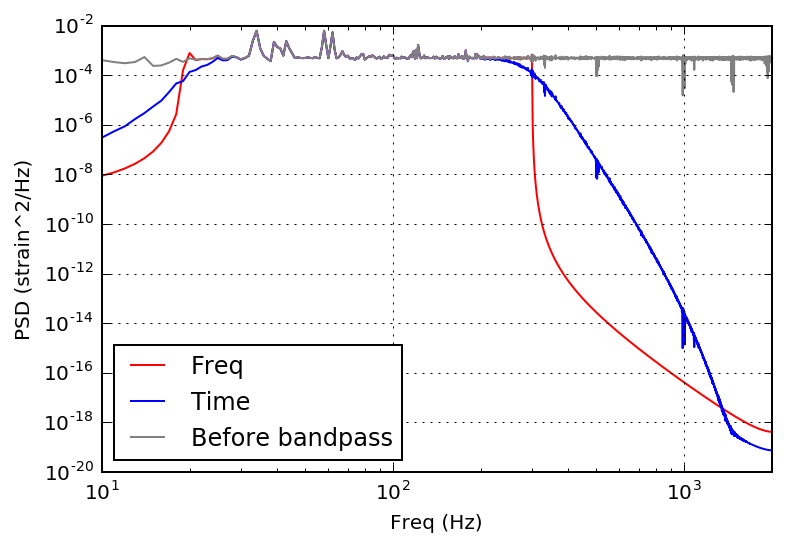

In [43]:
# Plot PSD on top of each other
line_f = plot_psd(strain_filtered_f, fs)
line_t = plot_psd(strain_filtered_t, fs)
line_w = plot_psd(strain_whiten, fs)
line_f.set_color('red')
line_t.set_color('blue')
line_w.set_color('gray')
line_f.set_label('Freq')
line_t.set_label('Time')
line_w.set_label('Before bandpass')
plt.legend(loc='lower left')

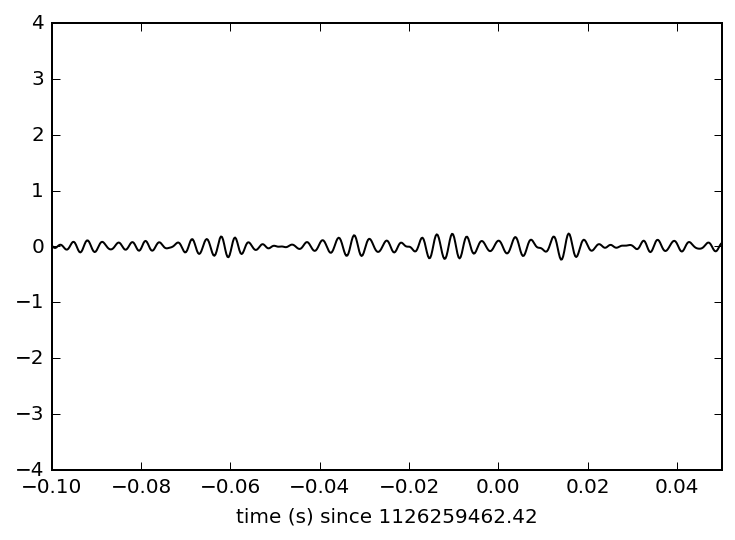

In [45]:
# Plot residual (freq_filtered - time_filtered)
line = plot_data(time - tevent, strain_filtered_f - strain_filtered_t)
line.set_color('black')

(-16.421999931335449, 15.577755928039551)

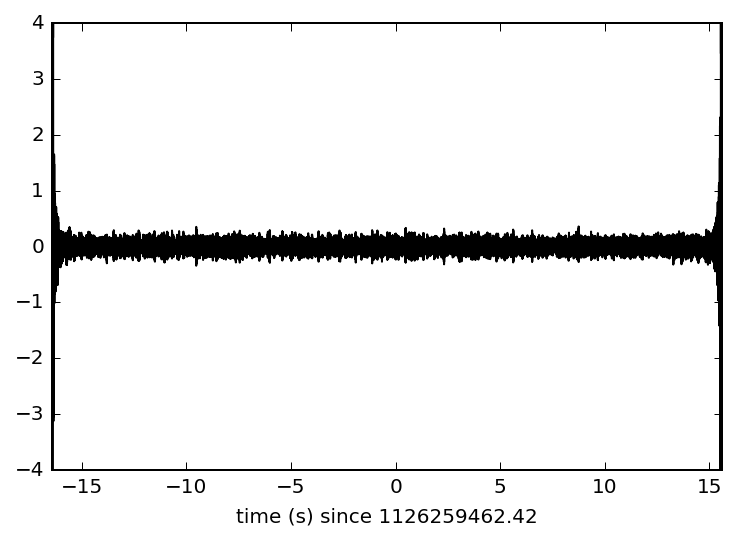

In [47]:
# Plot residual over entire domain (not just window of interest)
line = plot_data(time - tevent, strain_filtered_f - strain_filtered_t)
line.set_color('black')
plt.xlim(min(time - tevent), max(time - tevent))

In [46]:
min(time - tevent)

-16.421999931335449